In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install datasets
!pip install PyStemmer
!pip install scikit-plot

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 31.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.

In [2]:

import nltk
import torchtext
import torch
import torch.nn as nn
import os
import sys
import numpy as np
## imports 
import regex as re
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from nltk.tokenize import word_tokenize

import os
from datasets import load_dataset
from nltk.corpus import stopwords
from Stemmer import Stemmer
from torchtext import vocab
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)
from torch.utils.data import Dataset, DataLoader
import string


Device available now: cuda


In [3]:
stemmer = Stemmer('porter')
try:
    nltk.download("stopwords")
    nltk.download("punkt")
except:
    pass
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
sst_dataset = load_dataset("sst", "default")
nli_dataset = load_dataset("multi_nli")

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
print(sst_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 2210
    })
})


In [6]:
print(sst_dataset['train']['tokens'][0])

The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.


In [7]:
def tokenizer( wiki):
  # wiki = re.sub(r'[^\x00-\x7F]+', ' ', wiki)
  # wiki = re.sub('&amp;|&apos;|&gt;|&lt;|&nbsp;|&quot;', ' ', wiki)
  # wiki = re.split(r"[^A-Za-z0-9]+", wiki)
  wiki = wiki.translate(str.maketrans('', '', string.punctuation))
  wiki = word_tokenize(wiki)
  wiki = [word for word in wiki if not re.match(r'\d+', word) and len(word) > 1]

  wiki = [stemmer.stemWord(w.lower())for w in wiki if not w.lower() in stop_words and len(w) > 1]
  # wiki = wiki.split()
  return wiki
def setup_labels(data,id_list=['train','test','validation']):
  l=[]
  for id in id_list:

    for label in data[id]['label']:
      if(label>0.5):
       l.append(1)
      else:
        l.append(0)
  return np.array(l)


In [130]:
labels_sst=setup_labels(sst_dataset,id_list=['train'])
labels_sst_test=setup_labels(sst_dataset,id_list=['test'])
labels_sst_valid=setup_labels(sst_dataset,id_list=['validation'])

In [9]:
def sst_tokeniser(data,min_freq=5,id_list=['train','test','validation']):
  list_=[]
  d={}
  total_words=set()
  for id in id_list:
    tokens=data[id]['sentence']

    for tok in tokens:
      # print(tok)
      x=tokenizer(tok)
      list_.append(x)
      for word in x:
        if word in d:
          d[word]+=1
        else:
          d[word]=1
  vocablary = vocab.vocab(d,min_freq = min_freq,specials = ['<UNK>', '<PAD>'])

  vocablary.set_default_index(vocablary['<UNK>'])
  return list_,total_words,vocablary,d
  

    
list_sst,total_words_sst,vocabulary_sst,index_dict_sst=sst_tokeniser(sst_dataset)
print(len(vocabulary_sst))

3726


In [10]:
list_sst_test,total_words_sst_test,vocabulary_sst_test,index_dict_sst_test=sst_tokeniser(sst_dataset,id_list=['test'])
list_sst_valid,total_words_sst_valid,vocabulary_sst_valid,index_dict_sst_valid=sst_tokeniser(sst_dataset,id_list=['validation'])

In [11]:
list_sst_train,_,_,_=sst_tokeniser(sst_dataset,id_list=['train'])

In [12]:
def get_embedding_layer( vocabulary, embedding_dim):
        glove_vectors = vocab.GloVe(name = '6B', dim = embedding_dim)
        UNK_EMB = torch.mean(glove_vectors.vectors, dim=0)
        embeddings = []
        for word in vocabulary.get_itos():
            if word in glove_vectors.itos:
              embeddings.append(glove_vectors[word])
            else: 
              embeddings.append(UNK_EMB)
        embeddings = torch.stack(embeddings)
        embedding = nn.Embedding.from_pretrained(embeddings, freeze=True, padding_idx=vocabulary['<PAD>'])
        return embedding
embedding_sst=get_embedding_layer(vocabulary_sst,300)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.32MB/s]                           
100%|█████████▉| 399999/400000 [00:48<00:00, 8289.97it/s]


In [13]:
print(len(list_sst))

11855


In [14]:
# create dataset
          # x_padded_new=[0]*(maxlen-1-i)
          # x_padded_new+=seq[:i]
          # x.append(x_padded_new)
          # y.append(w)
def make_target_dataset(data,vocab):
  input=[]
  target=[]
  for i,sentence in enumerate(data):
    l=[]
    for w_idx in range(0,len(sentence)):
      word=sentence[w_idx]
      l.append(vocab([word])[0])
    input.append(l.copy())
    sentence.reverse()
    # l=[]
    # for w_idx in range(0,len(sentence)):
    #   word=sentence[w_idx]
    #   l.append(vocab([word])[0])
    # input.append(l.copy())

    # l=[]
    # for w_idx in range(len(sentence)-1,-1,-1):
    #   word=sentence[w_idx]
    #   l.append(vocab([word])[0])
    # input.append(l.copy())

  # print(input.shape,target.shape)

  return input
    
input_sst_util=make_target_dataset(list_sst,vocabulary_sst)


In [15]:
input_sst_util_train=make_target_dataset(list_sst_train,vocabulary_sst)


In [16]:
def prepare_sentence(seq, maxlen):
    # Pads seq and slides windows
    x = []
    y = []
    for i, w in enumerate(seq):
          # print(i)
          # print([seq[:i]])
          x_padded_new=[0]*(maxlen-1-i)
          x_padded_new+=seq[:i]
          x.append(x_padded_new)
          y.append(w)
    
    return x, y
def final_prep(tokenised_sequence):
  maxlen = max([len(seq) for seq in tokenised_sequence])
  x = []
  y = []
  for seq in tokenised_sequence:
      x_windows, y_windows = prepare_sentence(seq, maxlen)
      x += x_windows
      y += y_windows
  return torch.tensor(np.array(x)),torch.tensor(np.array(y))
input_sst,target_sst=final_prep(input_sst_util_train)

In [17]:
def prepare_sentence_(seq, maxlen):
    # Pads seq and slides windows
    x = []
    y = []
    length=len(seq)
    # for i, w in enumerate(seq):
    x_padded_new=[0]*(maxlen-length)
    x_padded_new+=seq[:length]
    return [x_padded_new]
def final_prep_(tokenised_sequence):
  maxlen = max([len(seq) for seq in tokenised_sequence])
  x = []
  y = []
  for seq in tokenised_sequence:
      x_windows = prepare_sentence_(seq, maxlen)
      # print(len(x_windows[0]))
      x += x_windows
  return torch.from_numpy(np.array(x))
sentence_sst=final_prep_(input_sst_util_train)

In [18]:
input_sst_util_test=make_target_dataset(list_sst_test,vocabulary_sst_test)
input_sst_test,target_sst_test=final_prep(input_sst_util_test)
sentence_sst_test=final_prep_(input_sst_util_test)

In [19]:
input_sst_util_valid=make_target_dataset(list_sst_valid,vocabulary_sst_valid)
input_sst_valid,target_sst_valid=final_prep(input_sst_util_valid)
sentence_sst_valid=final_prep_(input_sst_util_valid)

### nli

In [20]:
print(nli_dataset)

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


In [21]:
def nli_tokeniser(data,min_freq=5,id_list=['train','validation_matched','validation_mismatched']):
  list_=[]
  d={}
  label_nli=[]
  total_words=set()
  i=0
  for id in id_list:
    tokens=data[id]['premise']
    labels=data[id]['label']

    for tok,label in zip(tokens,labels):
      # sent=" ".join(tok.split('|'))
      if(label==-1):
        continue
      label_nli.append(label)
      # print(sent)
      x=tokenizer(tok)
      list_.append(x)
      for word in x:
        if word in d:
          d[word]+=1
        else:
          d[word]=1
      i+=1
      if(i>=40000):
        break
    if(i>=40000):
      break
  vocablary = vocab.vocab(d,min_freq = min_freq,specials = ['<UNK>', '<PAD>'])

  vocablary.set_default_index(vocablary['<UNK>'])
  return list_,total_words,vocablary,d,np.array(label_nli)
  

    


In [22]:
list_nli,total_words_nli,vocabulary_nli,index_dict_nli,label_nli=nli_tokeniser(nli_dataset)
list_nli_test,total_words_nli_test,vocabulary_nli_test,index_dict_nli_test,label_nli_test=nli_tokeniser(nli_dataset,id_list=['validation_matched'])
list_nli_valid,total_words_nli_valid,vocabulary_nli_valid,index_dict_nli_valid,label_nli_valid=nli_tokeniser(nli_dataset,id_list=['validation_mismatched'])

In [23]:
input_nli_util=make_target_dataset(list_nli,vocabulary_nli)
input_nli,target_nli=final_prep(input_nli_util)
sentence_nli=final_prep_(input_nli_util)

In [24]:
input_nli_util_test=make_target_dataset(list_nli_test,vocabulary_nli)
input_nli_test,target_nli_test=final_prep(input_nli_util_test)
sentence_nli_test=final_prep_(input_nli_util_test)

In [25]:
input_nli_util_valid=make_target_dataset(list_nli_valid,vocabulary_nli)
input_nli_valid,target_nli_valid=final_prep(input_nli_util_valid)
sentence_nli_valid=final_prep_(input_nli_util_valid)

In [26]:
embedding_nli=get_embedding_layer(vocabulary_nli,300)

### final elmo

In [136]:
BATCH_SIZE=128
class Elmo_bs(nn.Module):
    def __init__(self, vocab, embeddings, hid_size=300,PAD_VAL=0,num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(hid_size, hid_size, num_layers = num_layers, bidirectional=True, batch_first = True)
        self.pad = PAD_VAL
        # self.labels_num = 2 # for sst
        self.labels_num = 3 # for NLI

        self.embedding = embeddings
        self.weights = torch.rand(2)

        self.word_pred = nn.Linear(hid_size*2, len(vocab))
        self.classifier = nn.Linear(hid_size*2, self.labels_num)
        self.layers =num_layers
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        embed = self.embedding(x)

        a, (y, _) = self.lstm(embed)
        shape = y.shape
        y = torch.reshape(y,(shape[1],shape[0],shape[2]))
        y = torch.reshape(y,(shape[1], int(shape[0]/self.layers), self.layers, shape[2]))

        a = self.softmax(self.weights)
        a=torch.unsqueeze(a,1)
        a = torch.unsqueeze(torch.unsqueeze(a,0),0)
        a = a.repeat(shape[1], 2, 1, shape[2]).to(device)
        
        y = torch.mul(y, a)
        y = torch.sum(y, dim=2)
        y = torch.flatten(y,1,2)
        return y

In [119]:
# elmo=Elmo_bs(vocabulary_sst,embedding_sst).to(device)

# def pretrain_elmo_sst(model, input_data,target_data, num_epochs = 50,batch_size=BATCH_SIZE):
#     model = model.to(device)
#     inp_dataloader=DataLoader(input_data,shuffle=False,  batch_size=batch_size)
#     out_dataloader=DataLoader(target_data,shuffle=False,  batch_size=batch_size)

#     pad = vocabulary_sst['<PAD>']
#     loss_fn = nn.CrossEntropyLoss(ignore_index=pad).to(device)
#     # loss_fn = nn.CrossEntropyLoss().to(device)
#     optim = torch.optim.Adam(model.parameters(), lr=1e-3)
#     for epoch in tqdm(range(num_epochs), desc='epoch'):
#         model.train()
#         total_loss = 0
#         for ind,i in enumerate(zip(inp_dataloader,out_dataloader)):
#             x, label = i
#             x = x.to(device)
#             label = label.to(device)
#             optim.zero_grad()
#             # ans, ans2 = model(x, label)
#             ans = model(x)
#             ans = model.word_pred(ans)
#             loss = loss_fn(ans, label)
#             loss.backward()
#             optim.step()
#             total_loss += loss.item()
#         print(f'\tEpoch {epoch + 1}\tTrain Loss: {total_loss/len(input_data)}')
#     return model

# elmo = pretrain_elmo_sst(elmo, input_sst,target_sst)

In [ ]:
# for param in elmo.lstm.parameters():
#     param.requires_grad = False

In [44]:
# print(elmo)

Elmo_bs(
  (embedding): Embedding(3726, 300, padding_idx=1)
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, bidirectional=True)
  (word_pred): Linear(in_features=600, out_features=3726, bias=True)
  (classifier): Linear(in_features=600, out_features=3, bias=True)
)


In [ ]:
# print(len(sentence_sst))

8544


In [ ]:
# PATH="/content/saved_model_finetune_elmo.pth"
# elmo=Elmo_bs(vocabulary_sst,embedding_sst).to(device)
# elmo.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
# for param in elmo.lstm.parameters():
#     param.requires_grad = False

In [65]:
# def elmo_sst(model, input_data,target_data, num_epochs = 15,batch_size=BATCH_SIZE):
#     inp_dataloader=DataLoader(input_data,shuffle=False,  batch_size=batch_size)
#     out_dataloader=DataLoader(target_data,shuffle=False,  batch_size=batch_size)
#     model = model.to(device)
#     loss_fn = nn.CrossEntropyLoss().to(device)
#     optim = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
#         for ind, i in enumerate(zip(inp_dataloader,out_dataloader)):
#             x, label = i
#             x = x.to(device)
#             label = label.to(device)
#             # print(label)
#             optim.zero_grad()
#             ans = model(x)
#             ans = model.classifier(ans)
#             loss = loss_fn(ans, label)
#             loss.backward()
#             optim.step()
#             total_loss += loss.item()
#         print(f'\tEpoch {epoch + 1}\tTrain Loss: {total_loss/len(input_data)}')
#     return model

# elmo_s = elmo_sst(elmo, sentence_sst,labels_sst)

In [ ]:
# elmo_s=Elmo_bs(vocabulary_sst,embedding_sst).to(device)
# elmo_s.load_state_dict(torch.load(PATH))


In [ ]:
# torch.save(elmo.state_dict(), '/content/saved_model_final_pretrain_53.pth')


### try

In [73]:
model_sst=Elmo_bs(vocabulary_sst,embedding_sst).to(device)

optimizer_sst = optim.Adam(model_sst.parameters(),lr=0.001,weight_decay=1e-4)
criterion_sst = nn.CrossEntropyLoss(ignore_index = vocabulary_sst['<PAD>']).to(device)

def train(model,criterion,optim,batch_size,input_data,target_data,valid_in_data,valid_out_data,EPOCHS=25):

    min_valid_loss=1e9
    inp_dataloader=DataLoader(input_data,shuffle=False,  batch_size=batch_size)
    out_dataloader=DataLoader(target_data,shuffle=False,  batch_size=batch_size)
    valid_in_loader=DataLoader(valid_in_data,shuffle=False,  batch_size=batch_size)
    valid_out_loader=DataLoader(valid_out_data,shuffle=False,  batch_size=batch_size)

    for epoch in range(EPOCHS):
      model.train()
      epoch_loss = 0
      epoch_acc = 0

      for idx,data in enumerate(zip(inp_dataloader,out_dataloader)):
        x,y=data
        inputs = x.to(device)
        targets = y.to(device)
        # print(targets)

        outputs = model(inputs)
        outputs = model.word_pred(outputs)

        loss = criterion(outputs, targets)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item()

      epoch_loss = epoch_loss / len(input_data)
      print(f'Epoch {epoch}/{EPOCHS}\t Loss {epoch_loss}')
      valid_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for i, d in enumerate(zip(valid_in_loader,valid_out_loader)):
          data,labels=d
          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()
          
          target = model(data)
          loss = criterion(target,labels)
          valid_loss = loss.item() * data.size(0)

      if min_valid_loss > valid_loss and epoch>30:
          print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
          min_valid_loss = valid_loss
          # Saving State Dict
          torch.save(model.state_dict(), '/content/saved_model.pth')

    return model
model_sst=train(model_sst,criterion_sst,optimizer_sst,BATCH_SIZE,input_sst,target_sst,input_sst_valid,target_sst_valid)



Epoch 0/25	 Loss 0.05328701619340843


KeyboardInterrupt: ignored

8544


In [ ]:
# PATH="/content/drive/MyDrive/model_pretrained_sst.pth"
# torch.save(model_sst.state_dict(), PATH)

In [140]:
def train_pipe(model,criterion,optim,batch_size,input_data,target_data,valid_in_data,valid_out_data,EPOCHS=50):
    min_valid_loss=1e9
    inp_dataloader=DataLoader(input_data,shuffle=False,  batch_size=batch_size)
    out_dataloader=DataLoader(target_data,shuffle=False,  batch_size=batch_size)

    valid_in_loader=DataLoader(valid_in_data,shuffle=False,  batch_size=batch_size)
    valid_out_loader=DataLoader(valid_out_data,shuffle=False,  batch_size=batch_size)

    for epoch in range(EPOCHS):
      model.train()
      epoch_loss = 0
      epoch_acc = 0

      # print(len(input_data))
      # print(len(target_data))
      for idx,data in enumerate(zip(inp_dataloader,out_dataloader)):
        x,y=data
        inputs = x.to(device)
        targets = y.squeeze().to(device)
        optim.zero_grad()

        outputs = model(inputs)
        outputs = model.classifier(outputs)

        loss = criterion(outputs, targets)
        # backward pass
        loss.backward()
        optim.step()

        epoch_loss += loss.item()

      epoch_loss = epoch_loss / len(input_data)
      print(f'Epoch {epoch}/{EPOCHS}\t Loss {epoch_loss}')
      valid_loss = 0.0
      model.eval()     # Optional when not using Model Specific layer
      for i, d in enumerate(zip(valid_in_loader,valid_out_loader)):
          data,labels=d
          if torch.cuda.is_available():
              data, labels = data.cuda(), labels.cuda()
          target = model(data)
          labels = labels.squeeze().to(device)
          loss = criterion(target,labels)
          valid_loss = loss.item() * data.size(0)

      if min_valid_loss > valid_loss and epoch>10:
          print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
          min_valid_loss = valid_loss

          torch.save(model.state_dict(), '/content/saved_model_fine.pth')


    return model


def train_pipeline_main(vocab,embedding,PATH):
  model=Elmo_bs(vocab,embedding).to(device)
  model.load_state_dict(torch.load(PATH))
  for param in model.lstm.parameters():
    param.requires_grad = False
  print(model)
  optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=1e-4)
  criterion = nn.CrossEntropyLoss().to(device)

  model_finetuned=train_pipe(model,criterion,optimizer,BATCH_SIZE,sentence_sst,labels_sst,sentence_sst_valid,labels_sst_valid)
  return model_finetuned

model_sst_finetuned=train_pipeline_main(vocabulary_sst,embedding_sst,"/content/saved_model_final_pretrain_53.pth")

In [132]:
PATH="/content/saved_model_final_53.pth"
elmo_s=Elmo_bs(vocabulary_sst,embedding_sst).to(device)
elmo_s.load_state_dict(torch.load(PATH))


<All keys matched successfully>

[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 

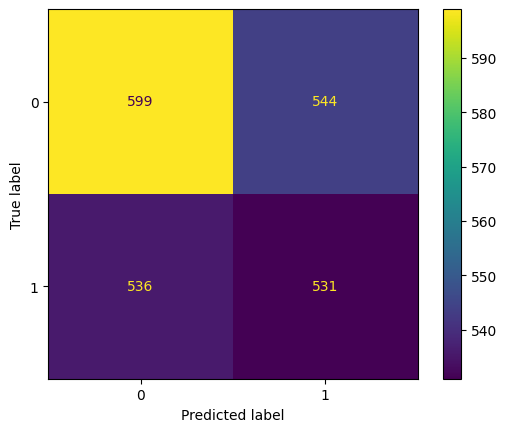

'\n'

In [133]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_stats(model, input_data,target_data,batch_size=BATCH_SIZE):
    true_labels = []
    predictions = []
    inp_dataloader=DataLoader(input_data,shuffle=False,  batch_size=batch_size)
    out_dataloader=DataLoader(target_data,shuffle=False,  batch_size=batch_size)
    model.eval()
    for i,batch in enumerate(zip(inp_dataloader,out_dataloader)):
        x, label = batch
        x = x.to(device)
        true_labels += label.tolist()
        pred_util = model.classifier(model(x))
        pred_util = nn.functional.softmax(pred_util, dim=1)
        pred_util = pred_util.argmax(dim=1)
        predictions += pred_util.tolist()
    print(predictions)
    model_labels=model.labels_num
    label_l=[]
    for i in range(model_labels):
      label_l.append(i)
    print('Classification Report:')
    print(classification_report(true_labels, predictions))
    print('\nConfusion Matrix:')
    cm = confusion_matrix(target_data, predictions, labels=label_l)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=label_l)
    disp.plot()
    plt.show()
    return "\n"
x = get_stats(elmo_s, sentence_sst_test,labels_sst_test)
x

### nli dataset

In [55]:
elmo_nli_pretrained=Elmo_bs(vocabulary_nli,embedding_nli).to(device)


In [137]:
model_nli=Elmo_bs(vocabulary_nli,embedding_nli).to(device)

optimizer_nli = optim.Adam(model_nli.parameters(),lr=0.001,weight_decay=1e-4)
criterion_nli = nn.CrossEntropyLoss(ignore_index = vocabulary_nli['<PAD>']).to(device)
model_nli=train(model_nli,criterion_nli,optimizer_nli,BATCH_SIZE,input_nli,target_nli,input_nli_valid,target_nli_valid)


KeyboardInterrupt: ignored

In [57]:
# torch.save(elmo_nli_pretrained.state_dict(), '/content/saved_model_nli.pth')


In [141]:
elmo_n=train_pipeline_main(vocabulary_nli,embedding_nli,"/content/saved_model_nli_34.pth")

Elmo_bs(
  (lstm): LSTM(300, 300, num_layers=2, batch_first=True, bidirectional=True)
  (embedding): Embedding(7554, 300, padding_idx=1)
  (word_pred): Linear(in_features=600, out_features=7554, bias=True)
  (classifier): Linear(in_features=600, out_features=3, bias=True)
  (softmax): Softmax(dim=0)
)
Epoch 0/50	 Loss 0.008780179287163953
Epoch 1/50	 Loss 0.0077071929008661584
Epoch 2/50	 Loss 0.007337386004822084
Epoch 3/50	 Loss 0.007098028464207935
Epoch 4/50	 Loss 0.006927319889546334
Epoch 5/50	 Loss 0.006797619603490562
Epoch 6/50	 Loss 0.006694297232989515


KeyboardInterrupt: ignored

In [146]:
PATH="/content/saved_model_nli_34.pth"
elmo_nli_finetune=Elmo_bs(vocabulary_nli,embedding_nli).to(device)
elmo_nli_finetune.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [78]:
print(label_nli_test)

[1 2 0 ... 0 0 2]


[1, 2, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 

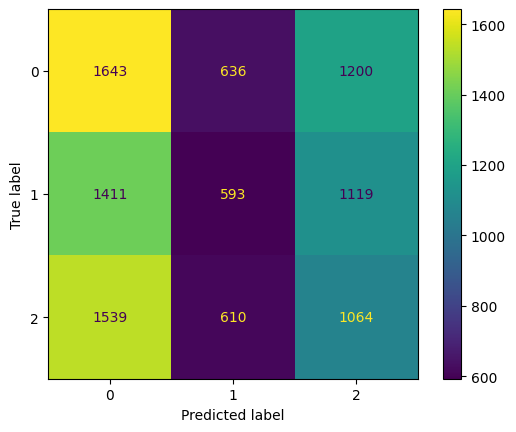

'\n'

In [147]:
x = get_stats(elmo_nli_finetune, sentence_nli_test,label_nli_test)
x


In [72]:
# torch.save(elmo_n.state_dict(), '/content/saved_model_nli_34.pth')


# ROC curve

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


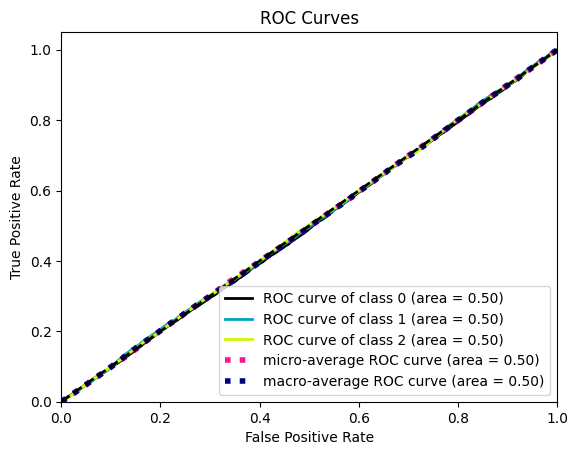

In [148]:
import scikitplot as skplt
import matplotlib.pyplot as plt
def roc_curve(model,input_data,target_data,batch_size=BATCH_SIZE):
    y_true = []
    y_pred = []
    inp_dataloader=DataLoader(input_data,shuffle=False,  batch_size=batch_size)
    out_dataloader=DataLoader(target_data,shuffle=False,  batch_size=batch_size)
    model.eval()
    for i,batch in enumerate(zip(inp_dataloader,out_dataloader)):
        x, label = batch
        x = x.to(device)
        y_true += label.tolist()
        preds = model(x)
        preds=model.classifier(preds)
        p = nn.functional.softmax(preds, dim=1).cpu().detach().numpy().tolist()
        y_pred+=p
    skplt.metrics.plot_roc_curve(y_true, y_pred)
    plt.show()
roc_curve(elmo_n,sentence_nli_test,label_nli_test)


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


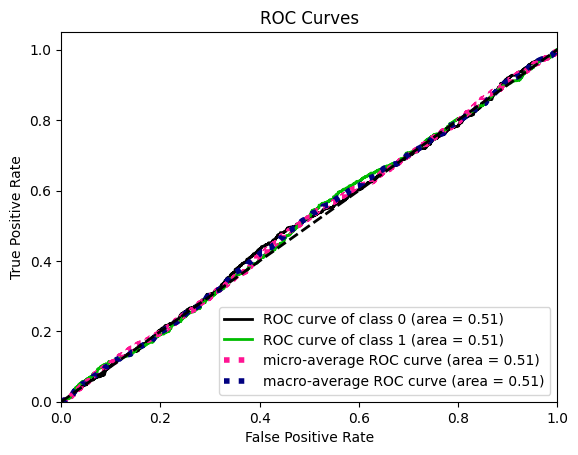

In [135]:
roc_curve(elmo_s,sentence_sst_test,labels_sst_test)
